In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import kagglehub
import cv2
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Amirreza\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [4]:
classes = ["angry", "fear", "happy", "sad", "surprise", "neutral"]

train_path = path + "/train"
test_path = path + "/test"

train_data = []
train_labels = []
test_data = []
test_labels = []

for i, c in enumerate(classes):
    for img in os.listdir(train_path + "/" + c):
        img = cv2.imread(train_path + "/" + c + "/" + img, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48,48))
        train_data.append(img)
        train_labels.append(i)
    for img in os.listdir(test_path + "/" + c):
        img = cv2.imread(test_path + "/" + c + "/" + img, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48,48))
        test_data.append(img)
        test_labels.append(i)

In [5]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
# Shuffle the data
idx = np.random.permutation(len(train_data))
train_data, train_labels = train_data[idx], train_labels[idx]

# Permute the data
idx = np.random.permutation(len(test_data))
test_data, test_labels = test_data[idx], test_labels[idx]

train_val_split = 0.2
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=train_val_split)

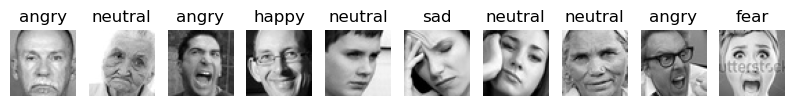

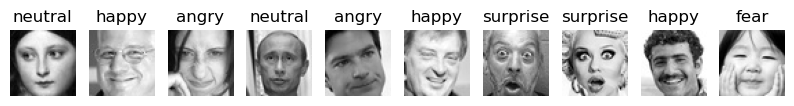

In [6]:
# Plot some images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_data[i], cmap='gray')
    plt.title(classes[train_labels[i]])
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_data[i], cmap='gray')
    plt.title(classes[test_labels[i]])
    plt.axis('off')
plt.show()

In [7]:
# Make labels one-hot
train_labels = np.eye(len(classes))[train_labels]
val_labels = np.eye(len(classes))[val_labels]
test_labels = np.eye(len(classes))[test_labels]

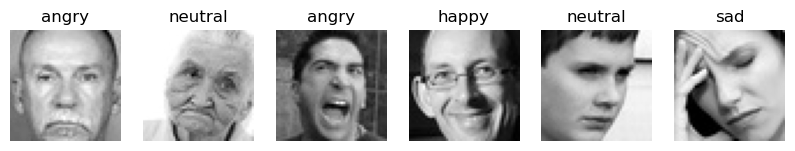

In [8]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(train_data[i], cmap='gray')
    plt.title(classes[np.argmax(train_labels[i])])
    plt.axis('off')

In [9]:
# Get dimensions of the data
n_samples, height, width = train_data.shape
n_classes = len(classes)
print("Number of samples:", n_samples)
print("Image dimensions:", height, width)
print("Number of classes:", n_classes)


Number of samples: 22618
Image dimensions: 48 48
Number of classes: 6


In [10]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(height*width, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, height*width)
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [123]:
image1 = train_data[0]
print("Image shape before flattening:", image1.shape)
model = SimpleModel()
model.eval()
output = model(torch.Tensor(image1))
print("Output shape:", output.shape)
print("Output:", output)

Image shape before flattening: (48, 48)
Output shape: torch.Size([1, 6])
Output: tensor([[1.8124e-33, 9.9998e-01, 0.0000e+00, 2.4133e-10, 2.0786e-05, 0.0000e+00]],
       grad_fn=<SoftmaxBackward0>)


In [124]:
def visualize_loss_and_acc(history_dict):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']

    epochs = range(1, len(acc) + 1)
    
    f = plt.figure(figsize=(10,3)) 

    plt.subplot(1,2,1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    acc_values = history_dict['acc']
    val_acc = history_dict['val_acc']
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [127]:
def train(model, train_data, train_labels, val_data, val_labels, n_epochs, batch_size, criterion, optimizer, print_every=3):
    
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(train_data), batch_size):
            data = torch.tensor(train_data[i:i+batch_size], dtype=torch.float32)
            labels = torch.tensor(train_labels[i:i+batch_size], dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
            train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
            train_outputs = model(train_data_tensor)
            train_loss = criterion(train_outputs, torch.max(train_labels_tensor, 1)[1])
            train_acc = accuracy_score(torch.max(train_labels_tensor, 1)[1], torch.max(train_outputs, 1)[1])

            val_data_tensor = torch.tensor(val_data, dtype=torch.float32)
            val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
            val_outputs = model(val_data_tensor)
            val_loss = criterion(val_outputs, torch.max(val_labels_tensor, 1)[1])
            val_acc = accuracy_score(torch.max(val_labels_tensor, 1)[1], torch.max(val_outputs, 1)[1])
            
            history['loss'].append(train_loss.item())
            history['acc'].append(train_acc)
            history['val_loss'].append(val_loss.item())
            history['val_acc'].append(val_acc)


        if epoch % print_every == 0:
            print("Epoch", epoch+1)
            print("Train loss:", "{:.8f}".format(history['loss'][-1]), "acc:", "{:.2f}".format(history['acc'][-1]))
            print("Val loss:", "{:.2f}".format(history['val_loss'][-1]), "acc:", "{:.2f}".format(history['val_acc'][-1]))
    
    return history


model = SimpleModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
history = train(model, train_data, train_labels, val_data, val_labels, n_epochs=20, batch_size=128, criterion=criterion, optimizer=optimizer)

Epoch 1
Train loss: 1.86470258 acc: 0.18
Val loss: 1.86 acc: 0.19
Epoch 4
Train loss: 1.85938740 acc: 0.18
Val loss: 1.85 acc: 0.19
Epoch 7
Train loss: 1.78671944 acc: 0.26
Val loss: 1.79 acc: 0.25
Epoch 10
Train loss: 1.78635848 acc: 0.26
Val loss: 1.79 acc: 0.25
Epoch 13
Train loss: 1.78619468 acc: 0.26
Val loss: 1.79 acc: 0.25
Epoch 16
Train loss: 1.78565490 acc: 0.26
Val loss: 1.79 acc: 0.25
Epoch 19
Train loss: 1.78624153 acc: 0.26
Val loss: 1.79 acc: 0.25


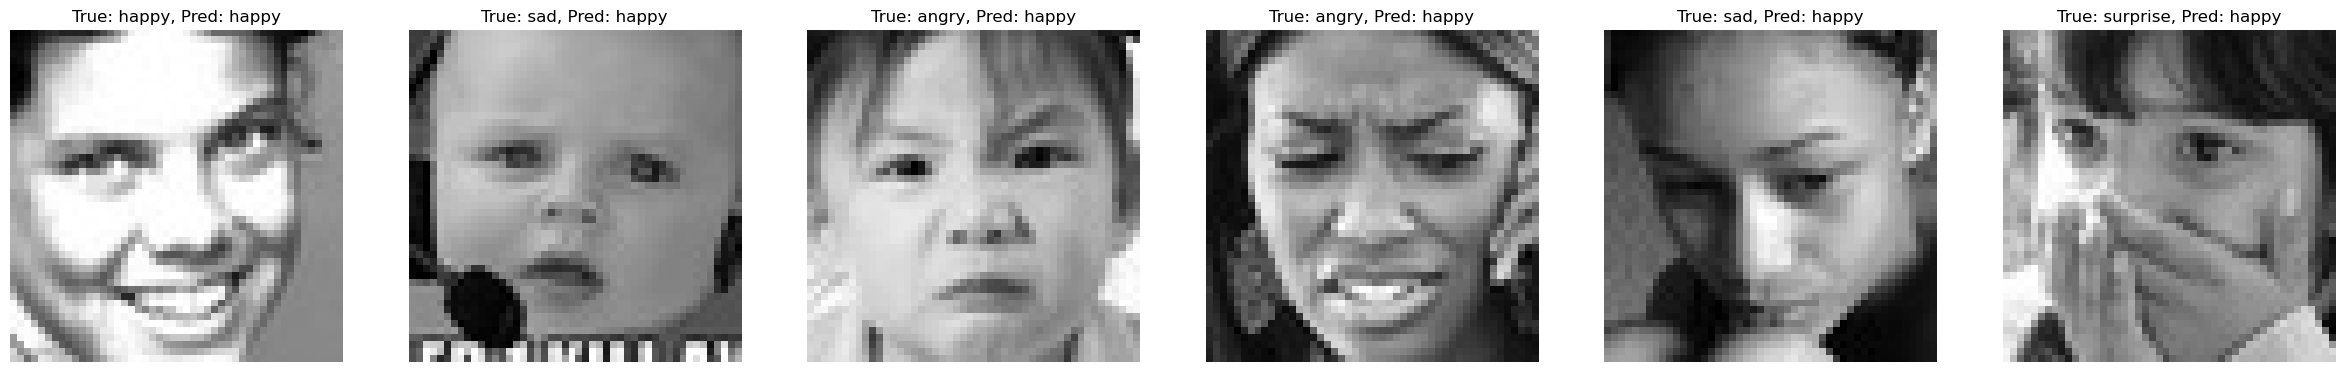

In [128]:
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data, dtype=torch.float32))
    predictions = torch.max(outputs, 1)[1]

plt.figure(figsize=(30,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(test_data[i+100], cmap='gray')
    plt.title(f"True: {classes[np.argmax(test_labels[i+100])]}, Pred: {classes[predictions[i+100]]}")
    plt.axis('off')

In [155]:
print(np.argmax(test_labels, axis=1))
print(np.array(predictions))

[1 1 3 ... 3 2 1]
[2 4 3 ... 5 2 0]


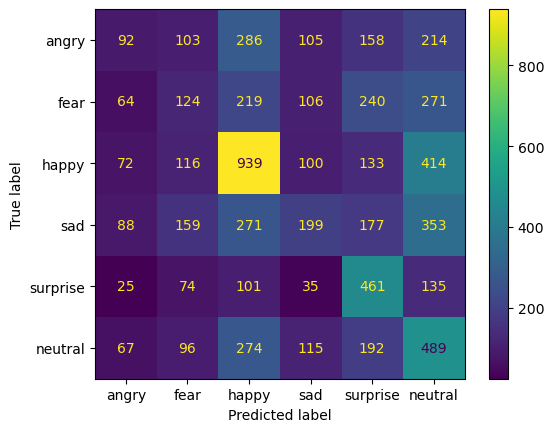

In [158]:
# Plot Confusion Matrix
classes = ["angry", "fear", "happy", "sad", "surprise", "neutral"]
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.array(predictions), labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()


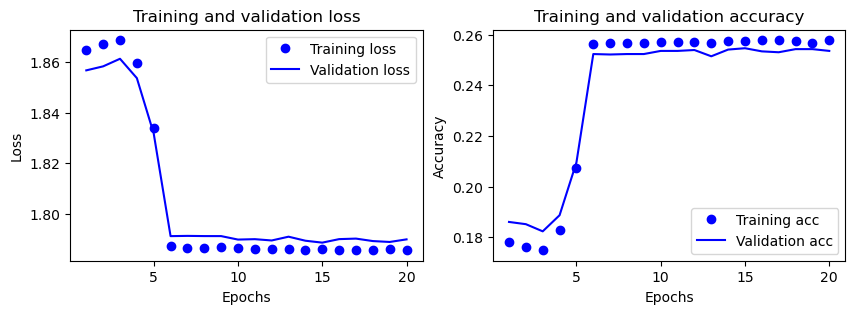

In [130]:
visualize_loss_and_acc(history)

In [131]:
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(height*width, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, height*width)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [163]:
model = ComplexModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
history = train(model, train_data, train_labels, val_data, val_labels, n_epochs=10, batch_size=128, criterion=criterion, optimizer=optimizer, print_every=1)

Epoch 1
Train loss: 1.79152215 acc: 0.25
Val loss: 1.82 acc: 0.23
Epoch 2
Train loss: 1.73096836 acc: 0.28
Val loss: 1.76 acc: 0.26
Epoch 3
Train loss: 1.70140922 acc: 0.29
Val loss: 1.74 acc: 0.27
Epoch 4
Train loss: 1.67565513 acc: 0.31
Val loss: 1.72 acc: 0.29
Epoch 5
Train loss: 1.65735447 acc: 0.33
Val loss: 1.71 acc: 0.30
Epoch 6
Train loss: 1.64189994 acc: 0.34
Val loss: 1.70 acc: 0.30
Epoch 7
Train loss: 1.62778854 acc: 0.35
Val loss: 1.69 acc: 0.31
Epoch 8
Train loss: 1.61789715 acc: 0.35
Val loss: 1.68 acc: 0.32
Epoch 9
Train loss: 1.61538303 acc: 0.35
Val loss: 1.68 acc: 0.31
Epoch 10
Train loss: 1.60622871 acc: 0.36
Val loss: 1.68 acc: 0.32


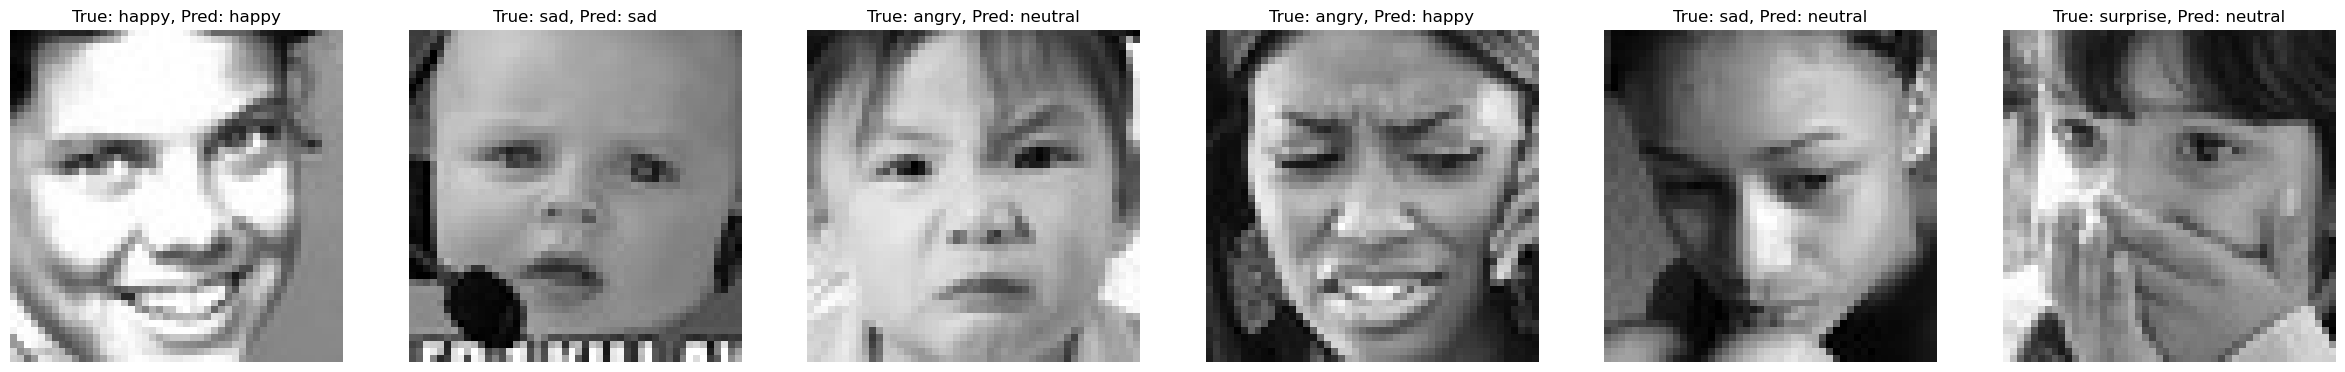

In [164]:
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data, dtype=torch.float32))
    predictions = torch.max(outputs, 1)[1]

plt.figure(figsize=(30,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(test_data[i+100], cmap='gray')
    plt.title(f"True: {classes[np.argmax(test_labels[i+100])]}, Pred: {classes[predictions[i+100]]}")
    plt.axis('off')

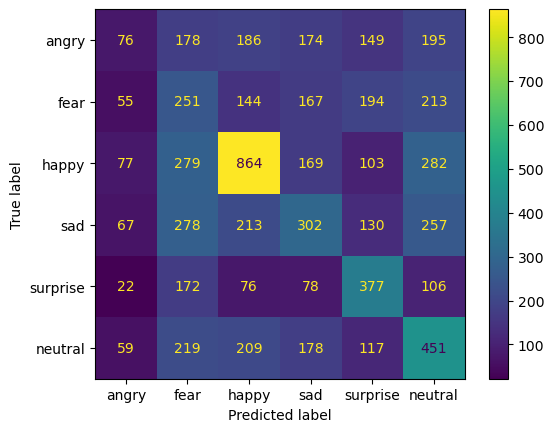

In [165]:
# Plot Confusion Matrix
classes = ["angry", "fear", "happy", "sad", "surprise", "neutral"]
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.array(predictions), labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()


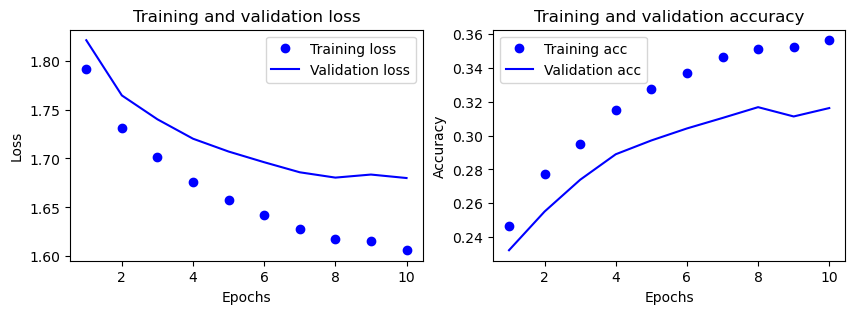

In [166]:
visualize_loss_and_acc(history)

In [167]:
epochs = [5, 10, 30]
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
optimizers = [torch.optim.SGD, torch.optim.Adam]
history_dict = {}
for epoch in epochs:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for optimizer in optimizers:
                model = ComplexModel()
                criterion = nn.CrossEntropyLoss()
                optimizer = optimizer(model.parameters(), lr=lr)
                history = train(model, train_data, train_labels, val_data, val_labels, n_epochs=epoch, batch_size=batch_size, criterion=criterion, optimizer=optimizer, print_every=epoch)
                history_dict[(epoch, lr, batch_size, optimizer)] = history
                

Epoch 1
Train loss: 1.74453497 acc: 0.28
Val loss: 1.78 acc: 0.26
Epoch 1
Train loss: 1.81487226 acc: 0.32
Val loss: 1.83 acc: 0.31
Epoch 1
Train loss: 1.82992649 acc: 0.27
Val loss: 1.85 acc: 0.27
Epoch 1
Train loss: 1.84988332 acc: 0.30
Val loss: 1.86 acc: 0.29
Epoch 1
Train loss: 2.00861669 acc: 0.23
Val loss: 2.03 acc: 0.22
Epoch 1
Train loss: 1.85928488 acc: 0.26
Val loss: 1.87 acc: 0.26
Epoch 1
Train loss: 1.78168070 acc: 0.17
Val loss: 1.79 acc: 0.17
Epoch 1
Train loss: 1.75822306 acc: 0.26
Val loss: 1.76 acc: 0.25
Epoch 1
Train loss: 1.79040647 acc: 0.11
Val loss: 1.80 acc: 0.11
Epoch 1
Train loss: 1.81339490 acc: 0.29
Val loss: 1.83 acc: 0.28
Epoch 1
Train loss: 1.76171219 acc: 0.23
Val loss: 1.77 acc: 0.24
Epoch 1
Train loss: 1.74976325 acc: 0.24
Val loss: 1.76 acc: 0.24
Epoch 1
Train loss: nan acc: 0.14
Val loss: nan acc: 0.14
Epoch 1
Train loss: 1.75940549 acc: 0.26
Val loss: 1.76 acc: 0.25
Epoch 1
Train loss: 1.77510858 acc: 0.26
Val loss: 1.78 acc: 0.25
Epoch 1
Train loss

Top 5 best accuracies:
Epochs: 30, Learning rate: 0.0001, Batch size: 32, Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
), Val acc: 0.37329796640141466
Epochs: 30, Learning rate: 0.0001, Batch size: 64, Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), Val acc: 0.36357206012378424
Epochs: 10, Learning rate: 0.0001, Batch size: 64, Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), Val acc: 0.3632183908045977
Epochs: 30, Learning rate: 0.0001, Batch size: 64, Optimizer: SGD (
Parameter Gr

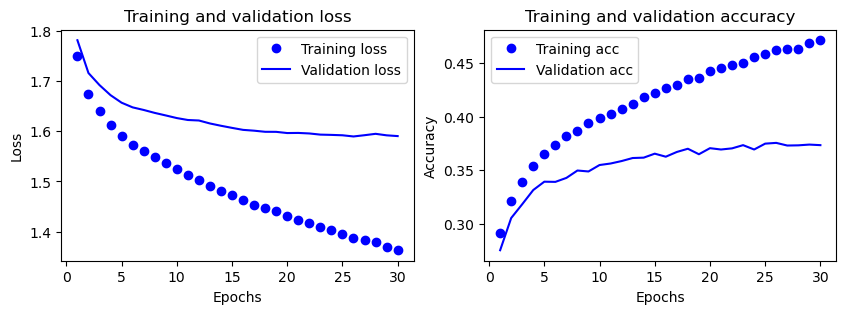

In [170]:
# find top 5 best accuracies
val_accs = []
for key, value in history_dict.items():
    val_accs.append((key, value['val_acc'][-1]))

val_accs.sort(key=lambda x: x[1], reverse=True)
print("Top 5 best accuracies:")
for i in range(5):
    print(f"Epochs: {val_accs[i][0][0]}, Learning rate: {val_accs[i][0][1]}, Batch size: {val_accs[i][0][2]}, Optimizer: {val_accs[i][0][3]}, Val acc: {val_accs[i][1]}")

best_params = val_accs[0][0]
print("Best parameters:", best_params)
# Visualize the best model
visualize_loss_and_acc(history_dict[best_params])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [22]:
def train_cuda(model, train_data, train_labels, val_data, val_labels, n_epochs, batch_size, criterion, optimizer, print_every=3):
    model.to(device)
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(n_epochs):
        model.train()
        accuracy_scores = []
        for i in range(0, len(train_data), batch_size):
            data = torch.tensor(train_data[i:i+batch_size], dtype=torch.float32).to(device)
            labels = torch.tensor(train_labels[i:i+batch_size], dtype=torch.float32).to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            acc = accuracy_score(torch.max(labels, 1)[1].cpu(), torch.max(outputs, 1)[1].cpu())
            accuracy_scores.append(acc)

        train_loss = loss
        train_acc = np.mean(accuracy_scores)
        
        model.eval()
        with torch.no_grad():
            val_data_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)
            val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).to(device)
            val_outputs = model(val_data_tensor)
            val_loss = criterion(val_outputs, torch.max(val_labels_tensor, 1)[1])
            val_acc = accuracy_score(torch.max(val_labels_tensor, 1)[1].cpu(), torch.max(val_outputs, 1)[1].cpu())
            
            history['loss'].append(train_loss.item())
            history['acc'].append(train_acc)
            history['val_loss'].append(val_loss.item())
            history['val_acc'].append(val_acc)


        if epoch % print_every == 0:
            print("Epoch", epoch+1)
            print("Train loss:", "{:.8f}".format(history['loss'][-1]), "acc:", "{:.2f}".format(history['acc'][-1]))
            print("Val loss:", "{:.2f}".format(history['val_loss'][-1]), "acc:", "{:.2f}".format(history['val_acc'][-1]))
    
    return history

In [23]:
class CNNModel(nn.Module):
    def __init__(self, n_classes =6):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*3*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 1, height, width)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256*3*3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [26]:
image1 = train_data[0]
height, width = image1.shape
n_classes = len(classes)
print("Image shape before flattening:", image1.shape)
model = CNNModel()
model.eval()
output = model(torch.Tensor(image1))
print("Output shape:", output.shape)
print("Output:", output)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

Image shape before flattening: (48, 48)
Output shape: torch.Size([1, 6])
Output: tensor([[0.0228, 0.4982, 0.1269, 0.0633, 0.0357, 0.2530]],
       grad_fn=<SoftmaxBackward0>)
Number of parameters: 1700870


In [25]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
learning_rates = [0.01, 0.001]
optimizers = [torch.optim.SGD, torch.optim.Adam]
history_dict_2 = {}
best_val_acc = 0
best_model = None
for lr in learning_rates:
    for optimizer in optimizers:
        model = CNNModel()
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer(model.parameters(), lr=lr)
        history = train_cuda(model, train_data, train_labels, val_data, val_labels, n_epochs=30, batch_size=32, criterion=criterion, optimizer=optimizer, print_every=1)
        history_dict_2[(lr, optimizer)] = history
        if history['val_acc'][-1] > best_val_acc:
            best_val_acc = history['val_acc'][-1]
            best_model = model
        

Epoch 1
Train loss: 1.70611298 acc: 0.26
Val loss: 1.74 acc: 0.29
Epoch 2
Train loss: 1.63901699 acc: 0.30
Val loss: 1.70 acc: 0.33
Epoch 3
Train loss: 1.58790076 acc: 0.34
Val loss: 1.68 acc: 0.35


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data, dtype=torch.float32).to(device))
    predictions = torch.max(outputs, 1)[1].cpu()

plt.figure(figsize=(30,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(test_data[i+100], cmap='gray')
    plt.title(f"True: {classes[np.argmax(test_labels[i+100])]}, Pred: {classes[predictions[i+100]]}")
    plt.axis('off')

In [ ]:
classes = ["angry", "fear", "happy", "sad", "surprise", "neutral"]
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.array(predictions), labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()

In [ ]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128*2*2, 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 1, height, width)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128*2*2)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Some Regularization Methods

1. **L1 Regularization (Lasso)**
   - Adds a penalty equal to the absolute value of the magnitude of the coefficients. 
   - $\lambda \sum_{i=1}^{n} |\theta_i|$
   - Encourages sparsity in the model by driving some coefficients to zero, effectively performing feature selection.

2. **L2 Regularization (Ridge)**
   - Adds a penalty equal to the square of the magnitude of the coefficients.
   - $\lambda \sum_{i=1}^{n} \theta_i^2$
   - Tends to distribute the weights across all features more evenly.

3. **Elastic Net**
   - Combines L1 and L2 regularization.
   - $\lambda_1 \sum_{i=1}^{n} |\theta_i| + \lambda_2 \sum_{i=1}^{n} \theta_i^2$
   - Adds both penalties to balance sparsity (from L1) and regularization strength (from L2).

4. **Data Augmentation**
   - Adds diversity to the training dataset by applying transformations to input data, such as rotation, scaling, or flipping.
   - Reduces overfitting by ensuring the model generalizes better to unseen data.
